<a href="https://colab.research.google.com/github/Baroucha1/ML/blob/main/Datamining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**
Pandas for data manipulation
transactionEncoder for transforming dataset


In [ ]:
import pandas as pd
import io
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Loading data**

In [ ]:


# Read the uploaded CSV file into a DataFrame
df = pd.read_csv('/content/sample_data/minindataset.csv')

data = pd.DataFrame(df)

data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,"489434,22041,""RECORD FRAME 7"""" SINGLE SIZE "",4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
401235,527870,22699,ROSES REGENCY TEACUP AND SAUCER,120.0,2010-10-19 11:36:00,2.55,16684.0,United Kingdom
401236,527870,21844,RED RETROSPOT MUG,108.0,2010-10-19 11:36:00,2.55,16684.0,United Kingdom
401237,527870,21974,SET OF 36 PAISLEY FLOWER DOILIES,144.0,2010-10-19 11:36:00,1.25,16684.0,United Kingdom
401238,527870,22423,REGENCY CAKESTAND 3 TIER,80.0,2010-10-19 11:36:00,10.95,16684.0,United Kingdom


# **Data cleaning**

In [ ]:
new_data = df.drop(['Quantity','InvoiceDate','Price','Customer ID','Country','Description'], axis=1)

We removed he columns Quantity, InvoiceDate, Price, CustomerID, country, Description from the DataFrame as they are not needed for the frequent itemset mining and association rule generation.

In [ ]:
new_data

,Invoice,StockCode
0,489434,85048
1,489434,79323P
2,489434,79323W
3,"489434,22041,""RECORD FRAME 7"""" SINGLE SIZE "",4...",NaN
4,489434,21232
...,...,...
401235,527870,22699
401236,527870,21844
401237,527870,21974
401238,527870,22423


In [ ]:
df_without_nan = new_data.dropna(how='any')
df_without_nan

,Invoice,StockCode
0,489434,85048
1,489434,79323P
2,489434,79323W
4,489434,21232
5,489434,22064
...,...,...
401235,527870,22699
401236,527870,21844
401237,527870,21974
401238,527870,22423


In [ ]:
# Remove rows where InvoiceNo starts with 'c'
df_without_nan = df_without_nan[~df_without_nan['Invoice'].str.startswith(('C', 'A'))]
df_without_nan

,Invoice,StockCode
0,489434,85048
1,489434,79323P
2,489434,79323W
4,489434,21232
5,489434,22064
...,...,...
401235,527870,22699
401236,527870,21844
401237,527870,21974
401238,527870,22423


We filter out the rows from the Dataframe where Invoice starts with C or A

# **Grouping Data**

In [ ]:
grouped_df = df_without_nan.groupby('Invoice')['StockCode'].apply(list).reset_index()
grouped_df

,Invoice,StockCode
0,489434,"[85048, 79323P, 79323W, 21232, 22064, 21871, 2..."
1,489435,"[22350, 22195, 22353]"
2,489436,"[48173C, 21755, 21754, 84879, 22119, 22142, 22..."
3,489437,"[22143, 22145, 22130, 21364, 21360, 21351, 213..."
4,489438,"[21329, 21252, 21100, 21033, 20711, 21410, 214..."
...,...,...
19135,527819,"[22034, 20975, 22435, 22271, 21004, 84029G, 84..."
19136,527827,"[85199S, 22837, 84029E, 21485, 21479, 21484, 2..."
19137,527841,"[84947, 84670, 21651, 21584, 35969, 22810, 228..."
19138,527853,"[21314, 22895, 22897, 72349B, 84707B, 22114, 2..."


We group the DataFrame by Invoice and aggregate the stockCode values into lists

In [ ]:
# Convert the grouped DataFrame to a list of lists (transactions)
transactions = grouped_df['StockCode'].tolist()
transactions

We convert the StockCode values into lists. The FP-growth algorithm requires the input data to be in a specific format known as a list of transactions, where each transaction is a list of items (in this case, StockCode values) that occur together in the same transaction (same InvoiceNo).

# **Transforming Data And Applying FP_Growth**

*For the next part we're going to be using One hot encoding*

One hot encoding is a process of converting categorical data into a format that can be provided to machine learning algorithms to improve predictions.In our case where we use Fp-growth algorithm, One-hot encoding is used to present the presence or absence of items ("StockCode")

One-hot encoding can lead to high-dimensional and sparse dataset when dealiing with large number of unique items this can result in increased memory usage and computational complexity. Howver, the Fp-growth algorithm is designed to efficiently handle this type of data structure.

Transaction Encoder is a utility class provided to transform the list of transactions into a one-hot encoded format
it works by identifying all unique items across all transactions and encoding them as binary vector ,if an item is present in transaction it will have the value of 1 otherwise 0

In [ ]:
#Initializing TransactionEncoder
te = TransactionEncoder()

In [ ]:
# Transforming the dataset into a one-hot encoded DataFrame
te_ary = te.fit(transactions).transform(transactions)
df_transformed = pd.DataFrame(te_ary, columns=te.columns_)

# Applying the FP-growth algorithm
frequent_itemsets = fpgrowth(df_transformed, min_support=0.03, use_colnames=True)

print("Frequent Itemsets:")
print(frequent_itemsets)

Frequent Itemsets:
     support          itemsets
0   0.072048           (21232)
1   0.057106           (21754)
2   0.055225           (84879)
3   0.048851           (21755)
4   0.037461           (21181)
..       ...               ...
73  0.039864           (22470)
74  0.030251   (85123A, 21733)
75  0.033542    (84991, 21212)
76  0.033804    (21232, 21231)
77  0.030146  (85099F, 85099B)

[78 rows x 2 columns]


after applying the Fp growth we can see that we have 78 frequent items with one beign 7% frequent as the highest and others at 3 %

# **Evaluating the results**

Association rules will provide insights into the relationships between the items and help identify strong associations between items that frequently occur together

Support is a measure of how frequently the antecedent and consquent of a rule appear toguther in the data set

Confidence is a measure of reliability of the rule it's calculated as the support of of both divided by the support of the antecedent.

Lift is a measure of how much likely the consequent is to be purshased given the antecedent is purshased



In [ ]:


# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display the association rules
print("Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Association Rules:
  antecedents consequents   support  confidence       lift
0     (21733)    (85123A)  0.030251    0.753906   5.426764
1     (84991)     (21212)  0.033542    0.572193   7.200371
2     (21231)     (21232)  0.033804    0.796798  11.059256
3    (85099F)    (85099B)  0.030146    0.629226   7.612756


after applying association rules we can see that we have 4 items having a 3% support of beign frequent toguther and with one beign reliable with 70% while other are over 50%

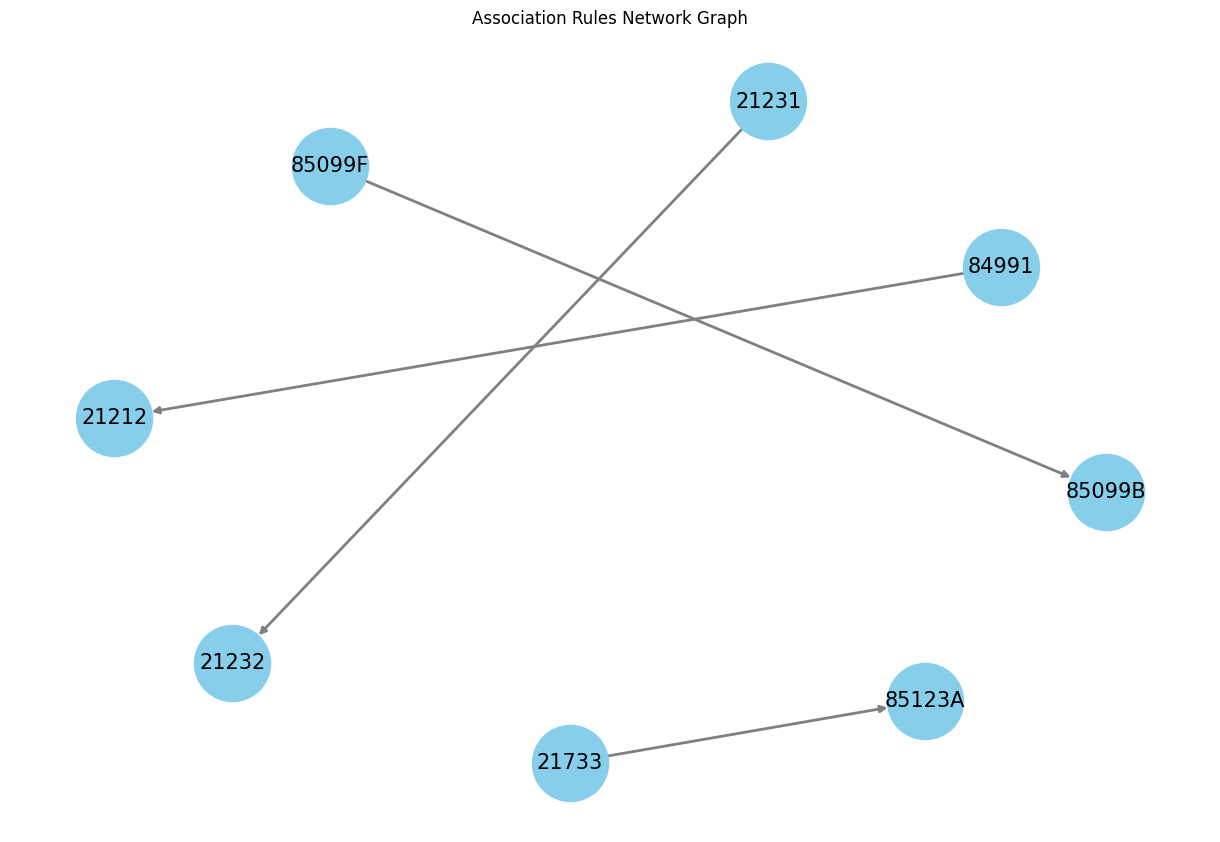

In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges between antecedents and consequents
for i in range(len(rules)):
    antecedent = ', '.join(list(rules.iloc[i]['antecedents']))
    consequent = ', '.join(list(rules.iloc[i]['consequents']))
    G.add_edge(antecedent, consequent, weight=rules.iloc[i]['support'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=10)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, width=2, edge_color='gray', arrows=True)
plt.title('Association Rules Network Graph')
plt.show()


<Figure size 1200x800 with 0 Axes>

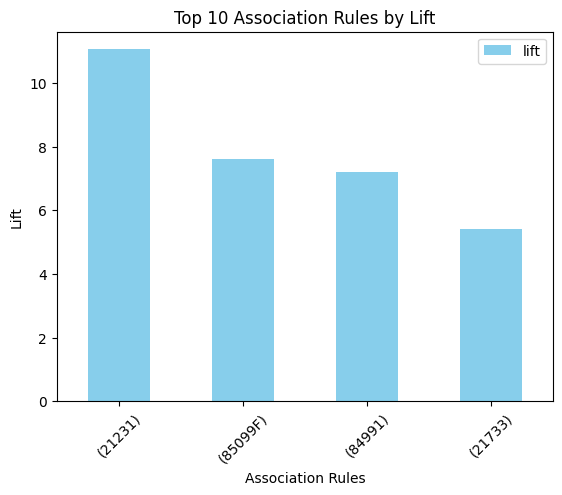

In [ ]:
# Sort the rules by lift in descending order and select the top N rules
top_rules = rules.sort_values(by='lift', ascending=False).head(10)

# Create a bar chart
plt.figure(figsize=(12, 8))
top_rules.plot(kind='bar', x='antecedents', y='lift', color='skyblue')
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Association Rules')
plt.ylabel('Lift')
plt.xticks(rotation=45)
plt.show()
